#**Speech Emotion Classifier, Model Trainer Notebook**

This notebook is very resource-intensive. It downloads a gigabyte worth of datasets, then it pre-processes them, and finally trains the model. It takes on average 3 hours for the notebook to completely run on Colab.

##**Part 1 - Setting up the environment, downloading datasets**

For this notebook, we need to install kwards, cinit, and kaggle modules.

In [62]:
!pip install kwargs  
!pip install cinit 
!pip install kaggle

Credentials for Kaggle API.

We need this for remotely downloading Kaggle datasets into this notebook.

In [63]:
import os
os.environ['KAGGLE_USERNAME'] = "aparker99"
os.environ['KAGGLE_KEY'] = "33de133161492f6af373277f54ffa5f6"

Download datasets

In [64]:
!kaggle datasets download -d ejlok1/cremad
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

cremad.zip: Skipping, found more recently modified local copy (use --force to force download)
ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)
surrey-audiovisual-expressed-emotion-savee.zip: Skipping, found more recently modified local copy (use --force to force download)
toronto-emotional-speech-set-tess.zip: Skipping, found more recently modified local copy (use --force to force download)


Paths for extracting datasets

In [65]:
# Paths for data.
Tess = "kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Ravdess = "kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Savee = "kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
Crema = "kaggle/input/cremad/AudioWAV/"

Create folders and extract datasets

In [66]:
!mkdir -p kaggle/input/ravdess-emotional-speech-audio/
!unzip ravdess-emotional-speech-audio.zip -d kaggle/input/ravdess-emotional-speech-audio

!mkdir -p kaggle/input/cremad
!unzip cremad.zip -d kaggle/input/cremad

!mkdir -p kaggle/input/surrey-audiovisual-expressed-emotion-savee/
!unzip surrey-audiovisual-expressed-emotion-savee.zip -d kaggle/input/surrey-audiovisual-expressed-emotion-savee/

Archive:  ravdess-emotional-speech-audio.zip
replace kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  cremad.zip
replace kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  surrey-audiovisual-expressed-emotion-savee.zip
replace kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_a01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [67]:
!mkdir -p "kaggle/input/toronto-emotional-speech-set-tess/tess toronto-emotional speech set data/"
!unzip toronto-emotional-speech-set-tess.zip -d "kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/"

Archive:  toronto-emotional-speech-set-tess.zip
replace kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [68]:
import pandas as pd, numpy as np
import os, sys

import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


Below we create setup the Ravdess dataset

In [69]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  kaggle/input/ravdess-emotional-speech-audio/au...
1   neutral  kaggle/input/ravdess-emotional-speech-audio/au...
2  surprise  kaggle/input/ravdess-emotional-speech-audio/au...
3  surprise  kaggle/input/ravdess-emotional-speech-audio/au...
4   disgust  kaggle/input/ravdess-emotional-speech-audio/au...

Below we create setup the Crema dataset

In [70]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                              Path
0    happy  kaggle/input/cremad/AudioWAV/1023_TIE_HAP_XX.wav
1  neutral  kaggle/input/cremad/AudioWAV/1009_TAI_NEU_XX.wav
2    angry  kaggle/input/cremad/AudioWAV/1070_IEO_ANG_MD.wav
3     fear  kaggle/input/cremad/AudioWAV/1079_IWW_FEA_XX.wav
4    happy  kaggle/input/cremad/AudioWAV/1068_IEO_HAP_HI.wav

Below we create setup the TESS dataset

In [71]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
             
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  surprise  kaggle/input/toronto-emotional-speech-set-tess...
1  surprise  kaggle/input/toronto-emotional-speech-set-tess...
2  surprise  kaggle/input/toronto-emotional-speech-set-tess...
3  surprise  kaggle/input/toronto-emotional-speech-set-tess...
4  surprise  kaggle/input/toronto-emotional-speech-set-tess...

Below we create setup the SAVEE dataset

In [72]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0  neutral  kaggle/input/surrey-audiovisual-expressed-emot...
1    happy  kaggle/input/surrey-audiovisual-expressed-emot...
2  disgust  kaggle/input/surrey-audiovisual-expressed-emot...
3    happy  kaggle/input/surrey-audiovisual-expressed-emot...
4  disgust  kaggle/input/surrey-audiovisual-expressed-emot...

Below we concatenate every dataset into one final dataframe 

In [73]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  kaggle/input/ravdess-emotional-speech-audio/au...
1   neutral  kaggle/input/ravdess-emotional-speech-audio/au...
2  surprise  kaggle/input/ravdess-emotional-speech-audio/au...
3  surprise  kaggle/input/ravdess-emotional-speech-audio/au...
4   disgust  kaggle/input/ravdess-emotional-speech-audio/au...

##**Part 2 - Analysis of the dataset**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


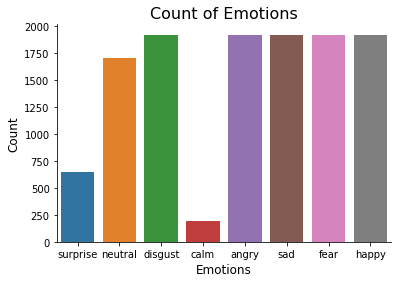

In [74]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [75]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

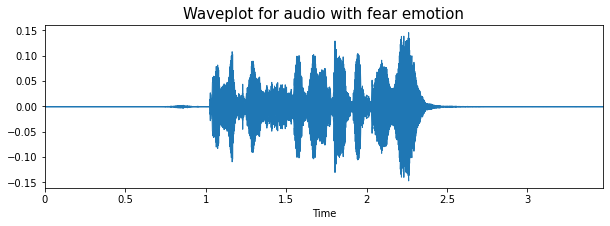

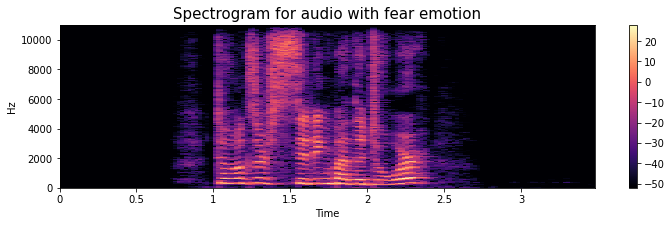

In [76]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

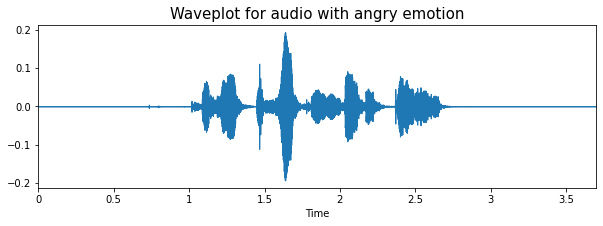

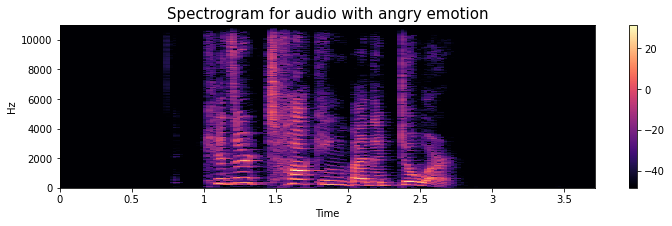

In [77]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

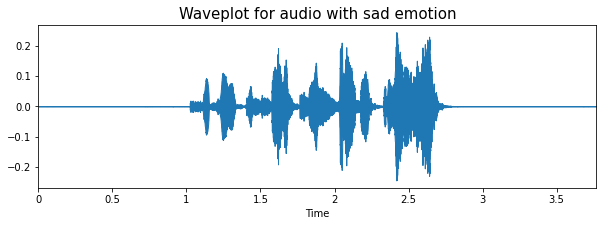

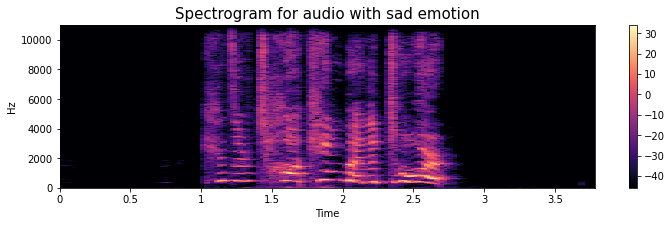

In [78]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

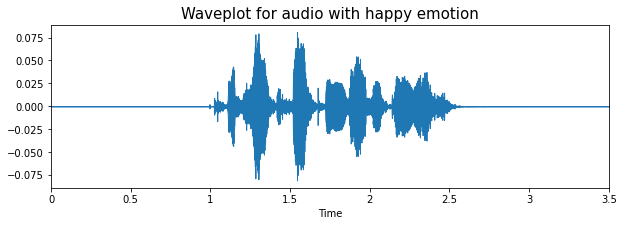

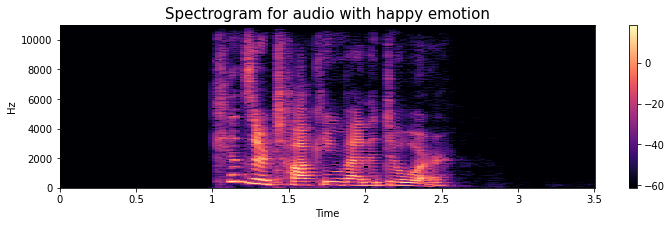

In [79]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [107]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

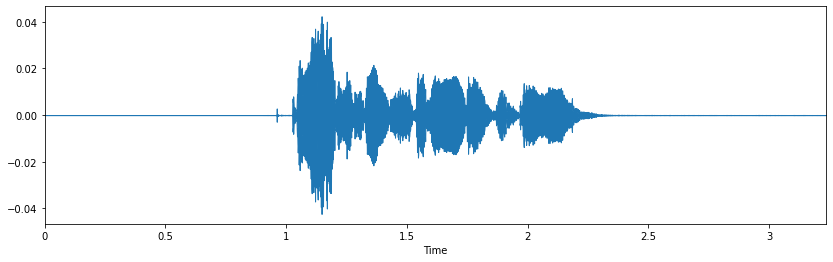

In [81]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

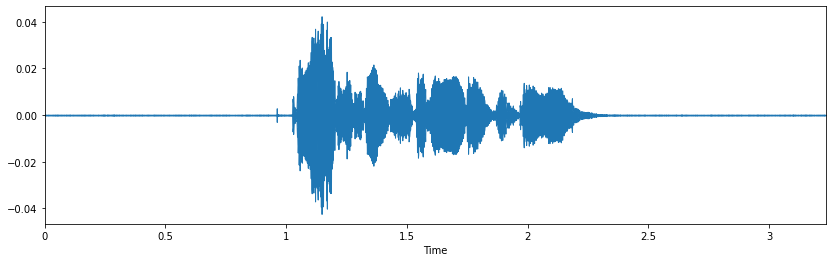

In [82]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

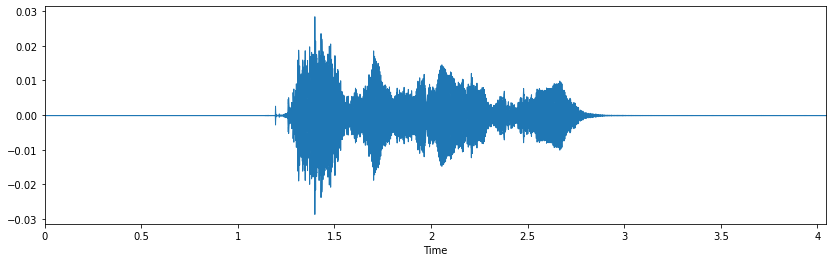

In [83]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

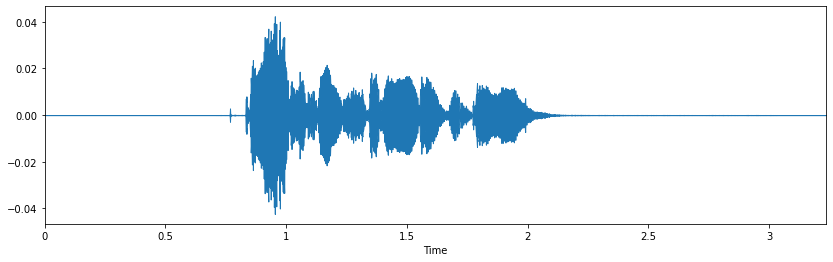

In [84]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

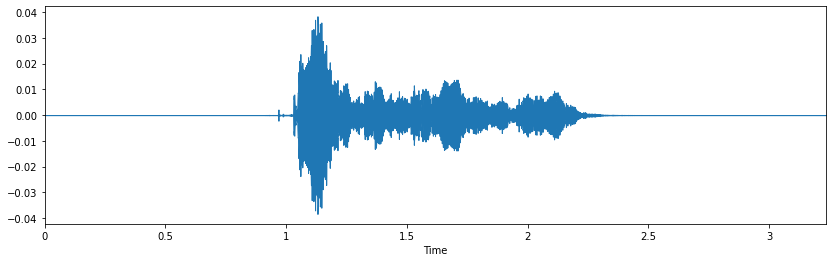

In [85]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

##**Part 3 - Pre-Processing Dataset**



To train the model on audio data, we need to first extract waveform features that make up the data.

The following features need to be computed: 

1. zero-crossing rate
2. chromagram 
3. mel-frequency cepstral coefficients 
4. root mean square values
5. mel spectogram

In the cell below are the functions to do just that.

Data is also augmented in the following functions.

In [86]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

**This cell of code takes more than one hour to run.**

In [87]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [88]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

**Creating features dataframe**

In [89]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2  ...       160           161    labels
0  0.285473  0.582885  0.576911  ...  0.000623  3.993223e-05  surprise
1  0.303892  0.673906  0.691158  ...  0.001211  5.845034e-04  surprise
2  0.183529  0.571380  0.568834  ...  0.000264  1.578731e-05  surprise
3  0.285771  0.592630  0.557961  ...  0.000016  8.979116e-07   neutral
4  0.341580  0.718914  0.739478  ...  0.000105  8.920928e-05   neutral

[5 rows x 163 columns]

In [90]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

As this is a multiclass classification problem, we need to hot encode our labels.

In [91]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

Splitting X (data entries), Y (data labels) into training and testing sets.

In [92]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [93]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

**Dump scaler object as "std_scaler.bin"**

We need this for audio pre-processing AFTER training our model and then saving it.

In [95]:
from joblib import dump, load
# dump scalar 
dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

Making  data compatible to model.


In [96]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

##**Part 4 - Model Definition** 

Create a temporal convolutional network with 6 layers in total.


In [99]:
# create model
model = Sequential()

# first cnn layer
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# second cnn layer
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# third cnn layer
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

# fourth cnn layer
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# fifth fully connected dense layer
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# sixth and final fully connected dense layer
model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

Train the model on x_train, y_train, and validate on x_test, y_test. We need to only run it for 50 epochs as after that it overfits.

##**Part 5 - Training Model**

In [100]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 196s 457ms/step - loss: 1.6867 - accuracy: 0.3240 - val_loss: 1.4594 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 195s 456ms/step - loss: 1.4455 - accuracy: 0.4152 - val_loss: 1.2911 - val_accuracy: 0.4754 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 196s 458ms/step - loss: 1.3541 - accuracy: 0.4537 - val_loss: 1.2718 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 192s 449ms/step - loss: 1.2979 - accuracy: 0.4751 - val_loss: 1.2502 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 192s 449ms/step - loss: 1.2632 - accuracy: 0.4918 - val_loss: 1.2021 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 192s 450ms/step - loss: 1.2340 - accuracy: 0.5025 - val_loss: 1.1699 - val_accuracy: 0.5283 - lr: 0.0010
Epoch 7/50
428/428 [==========================

Plot model training, validation  histories loss graph followed by another graph for accuracies.

##**Part 5 - Analysis of Results**

286/286 [==============================] - 14s 48ms/step - loss: 1.1026 - accuracy: 0.6060
Accuracy of our model on test data :  60.600745677948 %


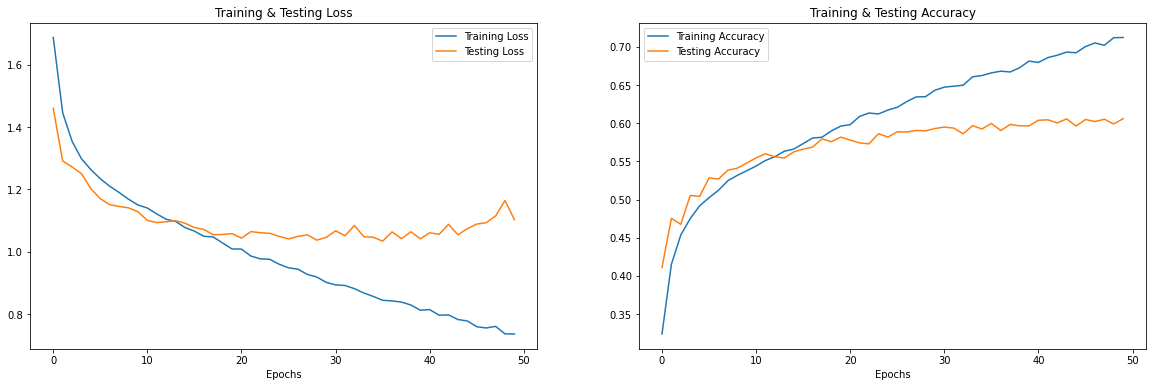

In [103]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [ i for i in range(50) ]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Run predictions on test data and inverse transform labels back into their original string format

In [104]:
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

Analyse predicted vs actual labels 

In [105]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear         happy
1         surprise      surprise
2         surprise      surprise
3          disgust         happy
4            angry          fear
5             fear          fear
6         surprise      surprise
7            angry         angry
8            happy         angry
9              sad           sad

Plot the error matrix for the model 

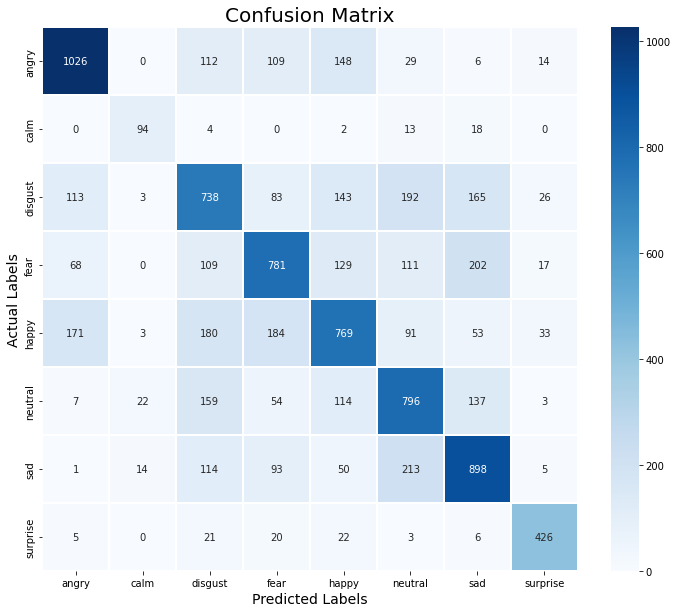

In [106]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## References 

1. Emotion detection using Speech, Notebook, https://www.kaggle.com/amitazadi/emotion-detection-using-speech/notebook
